# Ensemble Learning
#### **Simple rules for Ensemble Learning**
1. Ensure diversity among models
- The models should be diverse, they should make different kinds of errors.
    - Try different algorithms
2. Combine predictions effectively (voting, averaging, stacking)
- The way we combine predictions of individual models affects the ensemble's performanc
    - For classification: hard voting or soft voting
    - For regression: averaging or weighted averaging
3. Use boosting for weak models and bagging for independent models.
- Different algorithms train models in sequence, where each new model focuses on the mistakes of the previous ones.
4. Avoid overfitting by controlling model complexity
5. Balance bias and variance
- Ensembles work best when they balance bias (underfitting), and variance (overfitting)
    - Bagging reduces variance
    - Boosting reduces bias
6. Start simple and scale up as needed
7. Evaluate the ensemble rigorously
    - Cross validation
    - Compare

### 1. Overview 
The file contains data on 5000 costumers, this data include
- Age
- Income (anual in thousands i.e, 20, 20usd per year)

The customer's relationship with the bank
- Mortgage
- Securities account
- CCAvg, avg spending on credit cards per month

And customer response to last loan campaign (personal loan)


### 2. Importing libraries and reading the dataset

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
data = r"C:\Users\super\OneDrive\Escritorio\Vasudeva\Courses\ML Self Training\datasets\Bank_Personal_Loan_Modelling.csv"
loan = pd.read_csv(data)

### 3. Data preproccesing & visualization

In [ ]:
loan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


Lets drop useless columns

In [36]:
loan.drop(['ID'], axis=1, inplace=True)

In [37]:
loan.isnull().sum()

Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

No missing values


In [38]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal Loan       5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


Because usually default loan is predicted monthly, I will convert the annual income to month per month

In [39]:
loan['Income'] = loan['Income'].astype(float) / 12

Lets see if there are any miswritten value, like negative

In [40]:
(loan < 0).any()

Age                   False
Experience             True
Income                False
ZIP Code              False
Family                False
CCAvg                 False
Education             False
Mortgage              False
Personal Loan         False
Securities Account    False
CD Account            False
Online                False
CreditCard            False
dtype: bool

In [41]:
loan['Experience'] = abs(loan['Experience'])

Detecting noise values

[palettes](https://seaborn.pydata.org/tutorial/color_palettes.html)

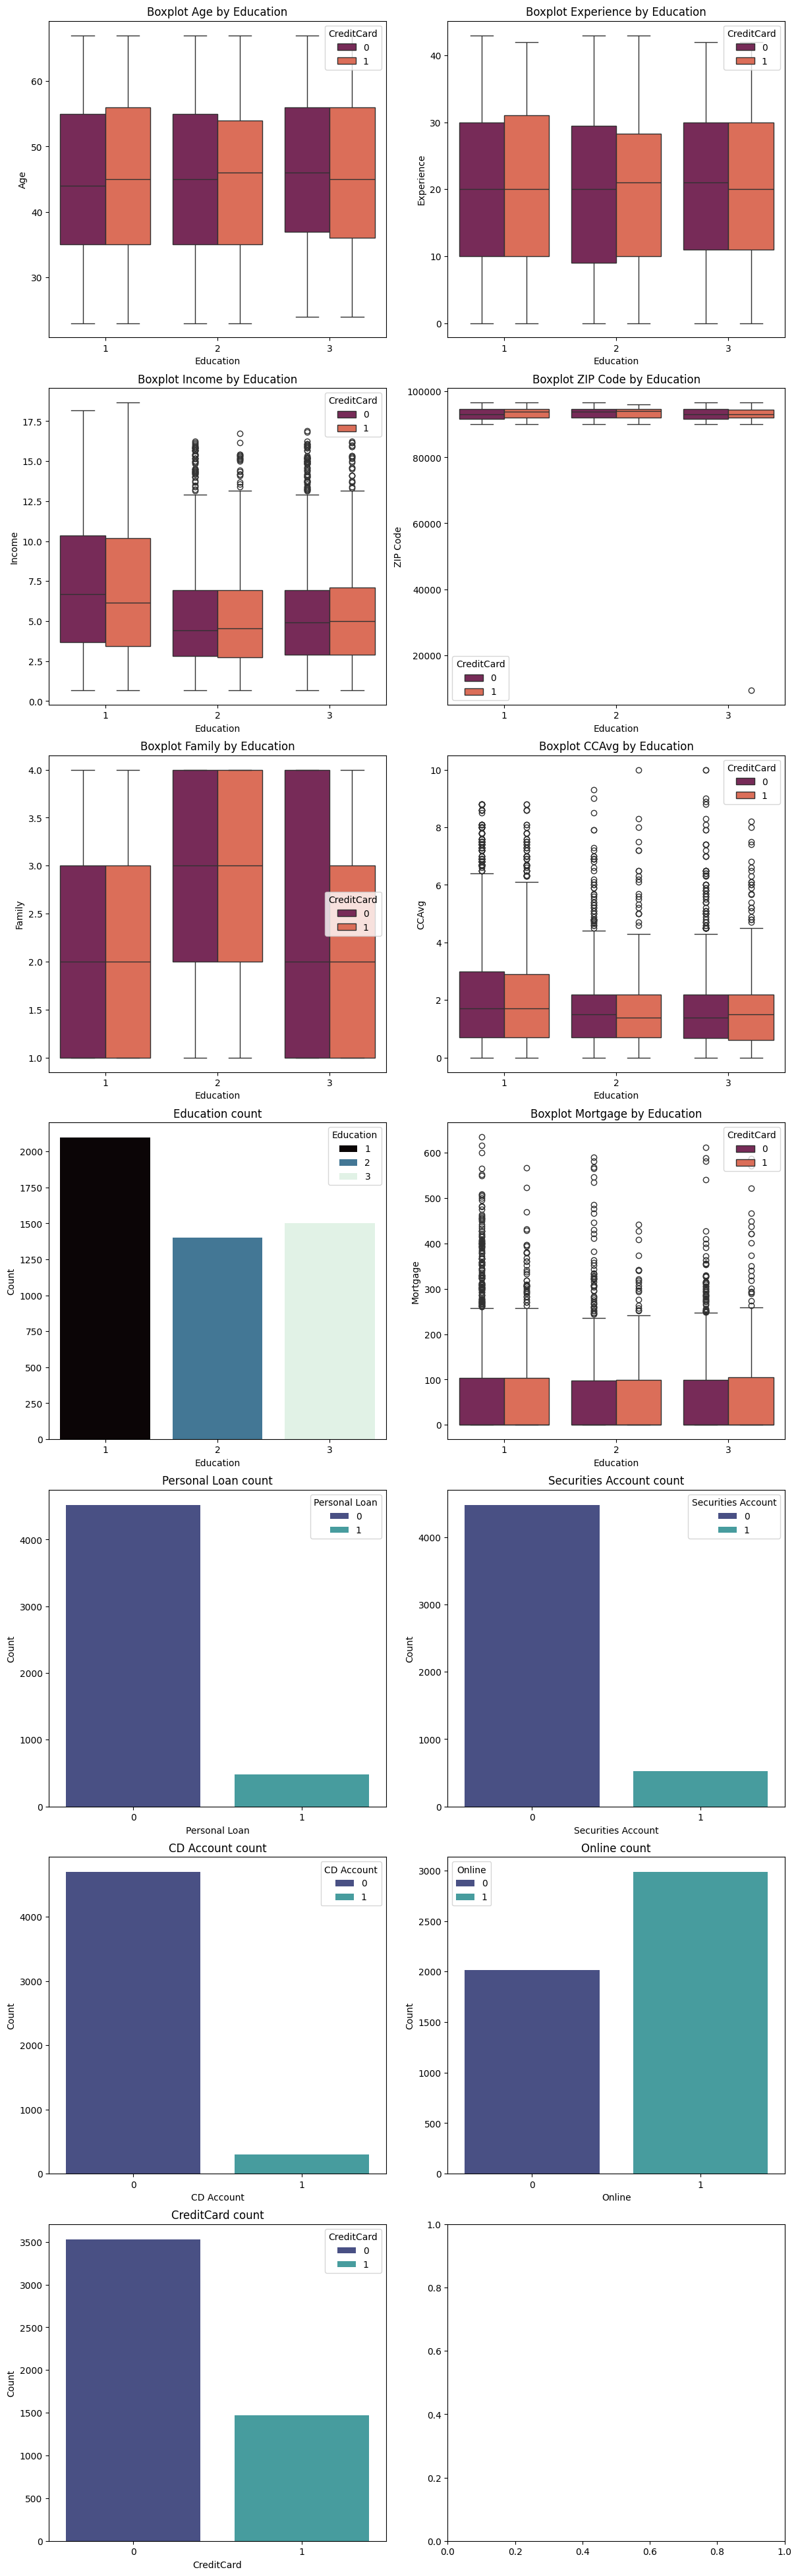

In [42]:
df_columns = tuple(loan.columns)
columns = df_columns
value = 'Education'
hue = 'CreditCard'

fig, axs = plt.subplots((len(columns) // 2) + (1 if len(columns) % 2 != 0 else 0) , ncols=2,
                        figsize=(12, len(columns)*3), layout='constrained')

axs = axs.flatten()

def boxplots(ax, fontsize=14):
    sns.boxplot(
        x=value,
        y=column,
        hue=hue,
        data=loan,
        palette='rocket',
        ax=ax
    )
    ax.set_title(f"Boxplot {column} by {value}")
    ax.set_xlabel(value)
    ax.set_ylabel(column)

def barplots(ax, fontsize=14, hide_labels = False):
    sns.countplot(x=column, ax=ax, palette='mako',
                  hue=column, data=loan)
    ax.set_title(f'{column} count')
    ax.set_ylabel('Count')

for i, column in enumerate(columns):
    unique_values = set(loan[column].unique())
    if unique_values =={0,1} or unique_values == {1, 2, 3}:
        barplots(axs[i], column)
    else:
        boxplots(axs[i], column)
        
plt.show()

As we see this distribution, we are detecting a noise value in zip, under 20000 is no a ZIP code so must be an error.

In [43]:
noise = loan[(loan['ZIP Code'] < 20000)]
noise

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
384,51,25,1.75,9307,4,0.6,3,0,0,0,0,1,1


In [44]:
loan.drop(index=[383], inplace=True)

In [45]:
loan.shape

(4999, 13)

noises have been detected and removed

Text(0.5, 1.0, 'Correlation Matrix')

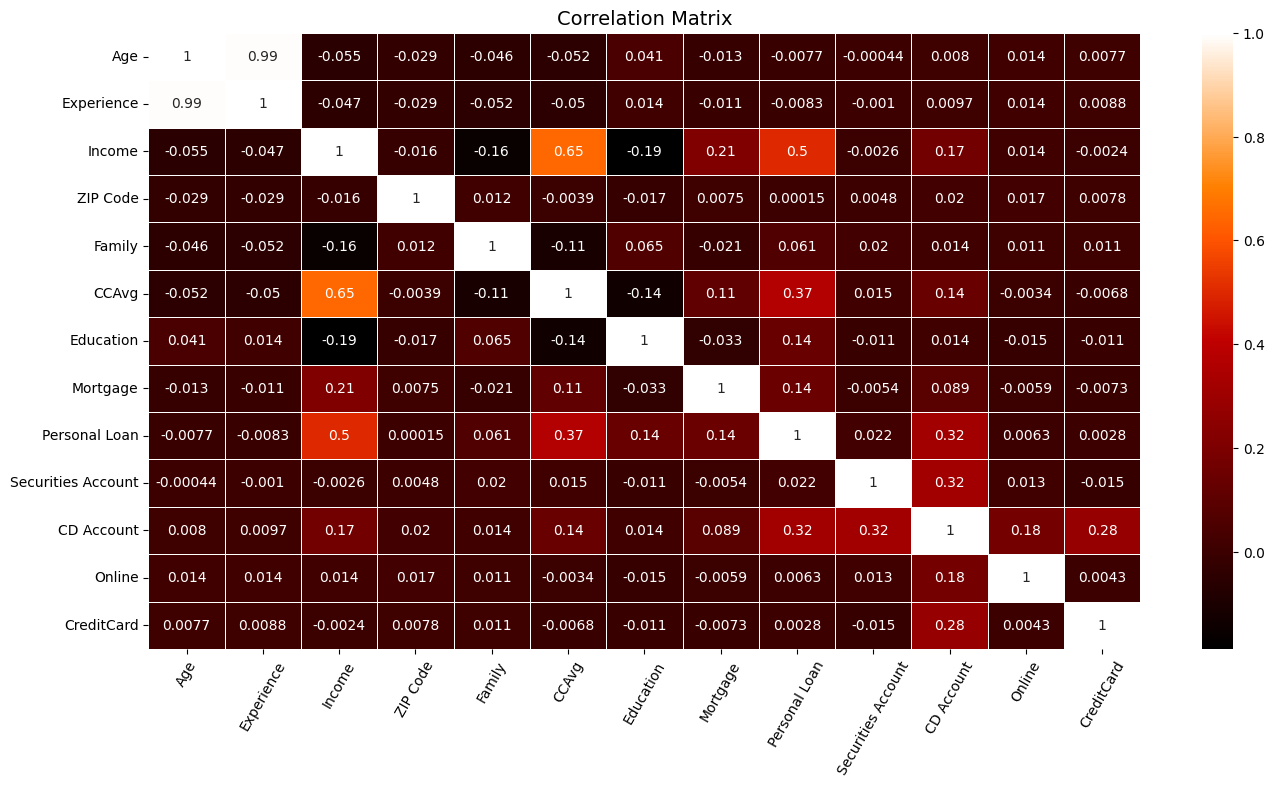

In [46]:
fig, ax = plt.subplots(figsize = (16, 8))
correlation_matrix = loan.corr()
sns.heatmap(correlation_matrix, cmap="gist_heat",
            annot=True, vmax=1, linewidths=.6) # there is no need to see -1 vmin
plt.xticks(rotation=60)
plt.title('Correlation Matrix', fontsize=14)


Because maybe I got an overfitting in the models, im going to see if CD Account and Securities account are valuable to Decision Trees based models in my case, because they got a bad balance as we see in the distribution plots.

CD account are valuable because it tell us if the person is financially educated and this is important to receive a loan.

In [49]:
# calculates the percentage of all binary columns
for col in df.columns:
    if loan[col].nunique() == 2:  
        percent = loan[col].value_counts(normalize=True) * 100
        print(f"\nPercentage of {col}:")
        print(f"No: {percent[0]:.2f}%")
        print(f"Yes: {percent[1]:.2f}")


Percentage of Personal Loan:
No: 90.40%
Yes: 9.60

Percentage of Securities Account:
No: 89.56%
Yes: 10.44

Percentage of CD Account:
No: 93.96%
Yes: 6.04

Percentage of Online:
No: 40.33%
Yes: 59.67

Percentage of CreditCard:
No: 70.59%
Yes: 29.41


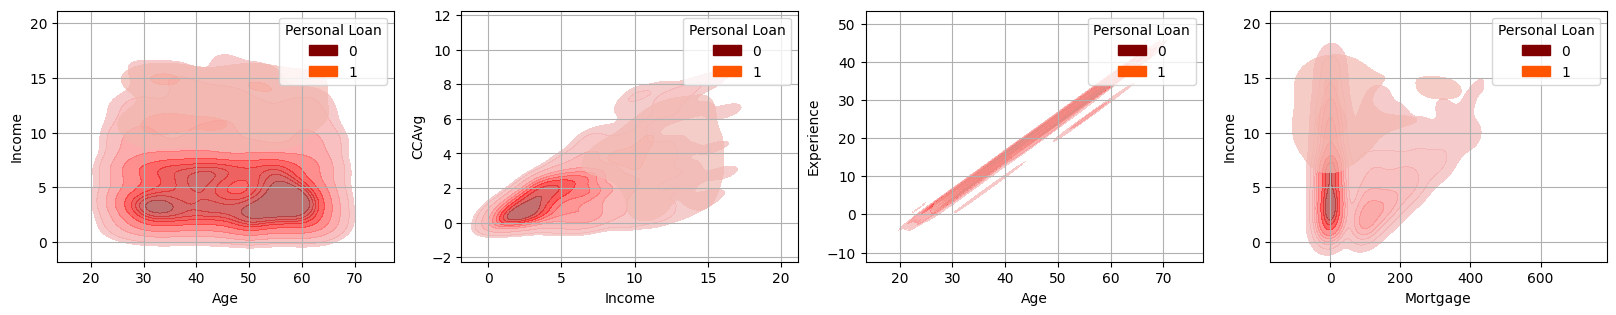

In [50]:
df = loan
plt.figure(figsize=(20,15))
plt.subplot(4,4,1)
sns.kdeplot(data=df,x='Age', y='Income', hue='Personal Loan',color='r',alpha=.7,weights=None,fill=True,multiple='fill',palette='gist_heat')
plt.grid()
plt.subplot(4,4,2)
sns.kdeplot(data=df,x='Income', y='CCAvg', hue='Personal Loan',color='r',alpha=.7,weights=None,fill=True,multiple='fill',palette='gist_heat')
plt.grid()
plt.subplot(4,4,3)
sns.kdeplot(data=df,x='Age', y='Experience', hue='Personal Loan',color='r',alpha=.7,weights=None,fill=True,multiple='fill',palette='gist_heat')
plt.grid()
plt.subplot(4,4,4)
sns.kdeplot(data=df,x='Mortgage', y='Income', hue='Personal Loan',color='r',alpha=.7,weights=None,fill=True,multiple='fill',palette='gist_heat')
plt.grid()

People with lower income can find harder to get a loan.

#### READY TO WORK !!!

In [51]:
X = loan.drop(['Personal Loan', 'ZIP Code', 'Education', 'Mortgage'], axis=1)
y = loan[['Personal Loan']].values.reshape(-1, 1)
X

,Age,Experience,Income,Family,CCAvg,Securities Account,CD Account,Online,CreditCard
0,25,1,4.083333,4,1.6,1,0,0,0
1,45,19,2.833333,3,1.5,1,0,0,0
2,39,15,0.916667,1,1.0,0,0,0,0
3,35,9,8.333333,1,2.7,0,0,0,0
4,35,8,3.750000,4,1.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
4995,29,3,3.333333,1,1.9,0,0,1,0
4996,30,4,1.250000,4,0.4,0,0,1,0
4997,63,39,2.000000,2,0.3,0,0,0,0
4998,65,40,4.083333,3,0.5,0,0,1,0


### 4. Essemble Learining models
#### **Bagging (Classification)** 
##### Decision Trees
Bagging makes use of an *ensemble* (a grab bag. perhaps), of paralell estimators, each of which overfits the data, and averages results to find a better classification. An ensemble of randomized decision trees is known as a *random forest*. 

Bagging doesnt have unique formula, but the predictions are described like:
$$
\hat{y} = mode(\hat{y}_i)
$$
- $\hat{y}_i$: is the i prediction of the basi model

In this case we are using Decision Trees as a basi model therefore the used metric to measuring the "purity" of a node is the **Gini Impurity**. Is used to know how to divide the data in each step of the tree:

$$
G(t)=1-\sum_{i=1}^{C}p(i|t)^{2}
$$
- $p(i|t)^{2}$: proportion of samples class of class $i$ at node $t$


Bagging (bootsrap aggregating) is general technique that can be apply to any model, not just to Decision Trees. When Decision Trees is used, each tree is a different subset of the dataset (replacement sampling) and then combine predictions.

[More information](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)



              precision    recall  f1-score   support

           0       0.95      1.00      0.97       900
           1       0.93      0.57      0.71       100

    accuracy                           0.95      1000
   macro avg       0.94      0.78      0.84      1000
weighted avg       0.95      0.95      0.95      1000

Cross Validation Score:  0.958


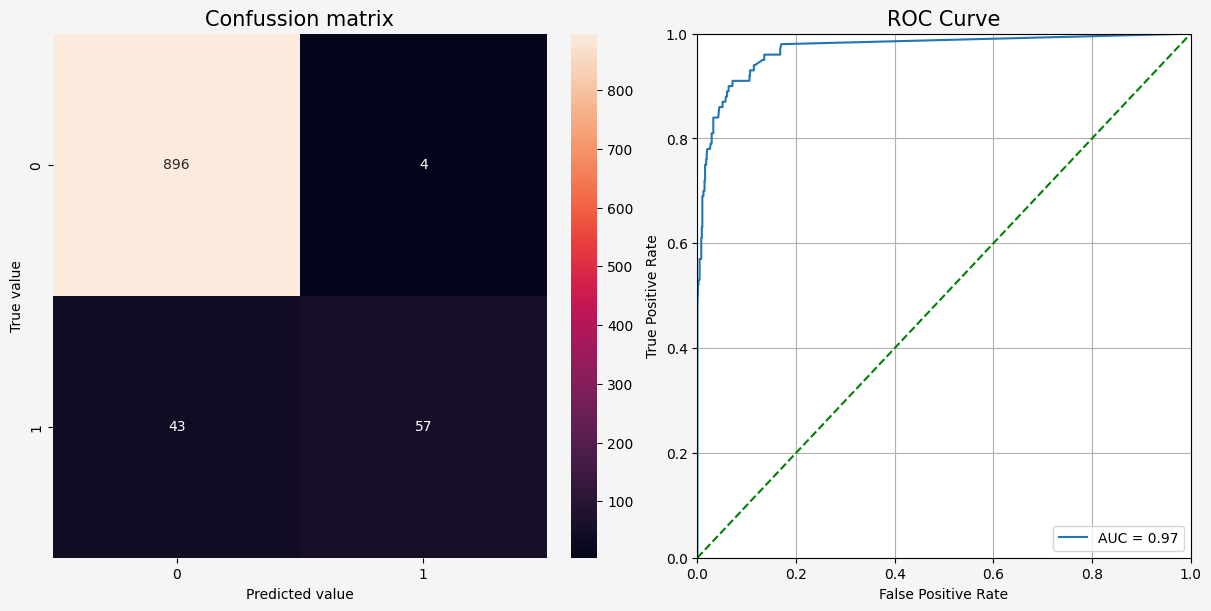

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.2, random_state=42)

# bagging with decision tree for clasification


bagging_clf_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion='log_loss',
                                     max_depth=10, 
                                     random_state=42), # default estimator is Decision Tree
    max_samples=.9,  # random subset of 90% of the training points
    n_estimators=17, # number of trees
    random_state=42
)
# 1. train the pipeline
bagging_clf_dt.fit(X_train, y_train)
# 2. predict in the set
y_pred = bagging_clf_dt.predict(X_test)
# 3. numeric evaluation accuracy, precision, recall, f1_score
print(classification_report(y_test, y_pred))
cv_bagging_clf_dt = cross_val_score(estimator=bagging_clf_dt, X=X_train, y=y_train, cv=10)
print(f"Cross Validation Score: {cv_bagging_clf_dt.mean(): .3f}")
# 4. graph evaluation
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout ='constrained')
fig.patch.set_facecolor('whitesmoke')

def cm_bag_dt(ax, fontsize = 14):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('True value')
    ax.set_title('Confussion matrix', fontsize=fontsize+1)

def curve_bag_dt(ax, fontsize = 14):
    y_pred_proba = bagging_clf_dt.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label =f'AUC = {auc:.2f}')
    ax.plot([0, 1], [0, 1], linestyle='--', color = 'green')
    ax.grid('-')
    ax.set_xlim(0, 1)  # Límites del eje x
    ax.set_ylim(0, 1)  # Límites del eje y
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title('ROC Curve', fontsize=fontsize+1)
    ax.legend()

cm_bag_dt(axs[0], fontsize=14)
curve_bag_dt(axs[1], fontsize = 14)

#### **Boosting (Classification)**
Gradient Boosting is a general framework for building ensemble models that combine multiple weak models (usually decision trees) sequentially to create a strong model. All three methods (XGBoost, LightGBM and CatBoost) follow this approach, so they share the same key equations.

`Equations` 

These equations are **universal** to the methods based in **Gradient Boosting**

a) Loss function

- *Regression*: Mean Squared Error (MSE)
$$
L=\sum_{i=1}^{n}(y_i-\hat{y_i})^2
$$
- *Classification*: Log-loss
$$
L = -\sum_{i=1}^{n} [y_i\log{\hat{y_i}+(1+y_i)\log(1-\hat{y_i})}]
$$
b) Objective Function

$Obj$ includes the loss function and a term of regularization ($\Omega$) to avoid overfitting:
$$
Obj=\sum_{i=1}^{n}L(y_i,\hat{y_i})+\sum_{k=1}^{K}\Omega(f_k)
$$
- $L(y_i,\hat{y_i})$: Loss function
- $\Omega(f_k)$: Regularization term for k-th tree

c) Regularization term 

The regularization term $\Omega$ penalizes the complexity of the model:
$$
Omega(f_k) = \gamma T+\frac{1}{2}\lambda\sum_{j=1}^{T}\omega^2
$$
- $T$: Number of leaves of the tree
- $\omega^2$: j-th leave weight
- $\gamma,\lambda$: hyperparameters of the regularization

d) Predict updating

In each iteration, the predictions updates like:
$$
\hat{y_i}^{t}=\hat{y_i}^{t-1}+\eta f_t(x_i) 
$$
- $\hat{y_i}^{t}$: Iteration of prediction $t$
- $\eta$: Learning rate (controls the distribution of each tree)
- $f_t(x_i)$: Prediction of each tree in iteration $t$



#### Gradient Boosting Classifier
`Gradient Boosting Classifier` is a supervised learning algorithm that belongs to the family of ensemble methods. Ensemble methods combine multiple (usually simple) weak models to create a more robust and accurate model. In particular, Gradient Boosting is noted for its ability to iteratively improve predictions by correcting errors from previous models.

`How it works?`

**1. Sequential weak models**
- Unlike other ensemble methods such as Bagging (e.g. Random Forest), which trains models in parallel, Gradient Boosting trains models sequentially. Each new model focuses on correcting errors made by previous models.

**2. Loss function minimization**
- The algorithm uses the downward gradient to minimize a loss function (e.g., cross entropy in sorting).
At each iteration, a new model is trained to predict the negative gradient of the loss function with respect to previous predictions.

**3. Pondered combination**
- Predictions of all models are combined in a weighted manner, giving more weight to the models that contributes more to reducing the error

**4. Iterations until convergence**
- This process is repeated until the error is small enough or the max number of iterations is reached.

`Hyperparameters`
- *n_estimators*: Number of weak models (trees) to be trained
- *learning_rate*: Controls the contribution of each model to the final result. A lower value requires more models but may improve generalization
- *max_depth*: Max depth of each tree. Controls the complexity of the model
- *min_samples_split*: Minimun required samples to divide a node
- *loss*: Loss function to minimize (i.e, deviance for cross entropy)
- $\dots$ [Check documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#gradientboostingclassifier)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       900
           1       0.96      0.66      0.78       100

    accuracy                           0.96      1000
   macro avg       0.96      0.83      0.88      1000
weighted avg       0.96      0.96      0.96      1000

Cross Validation Score:  0.958


np.float64(0.038)

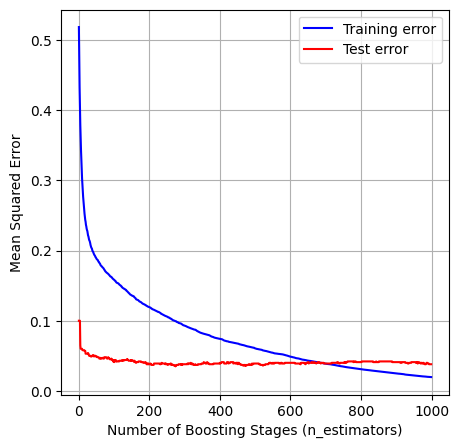

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

model_gbc = GradientBoostingClassifier(n_estimators=1000,
                                       max_depth=3,
                                       random_state=42
                                       )
# 1. train the model
model_gbc.fit(X_train, y_train)
# 2. predict the test of the data
test_error = np.zeros_like(model_gbc.train_score_)
# 3. metric evaluation
print(classification_report(y_test, y_pred))
cv_gbc_cf = cross_val_score(estimator=model_gbc, X=X_train, y=y_train, cv=5)
print(f"Cross Validation Score: {cv_gbc_cf.mean(): .3f}")

# 4. plot evaluation

# staged_predict allows to get the predictions in each step (n_estimators)
# of the training process
for idx, y_ in enumerate(model_gbc.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)


plot_idx = np.arange(model_gbc.train_score_.shape[0]) # np.arange(n_estimators)
fig, ax = plt.subplots(figsize=(5,5)) # second element of tuple [1]
                                      # ax = plt.subplots(figsize=(5,5))[1]                                 
ax.plot(plot_idx,
        model_gbc.train_score_,
        'b',
        label='Training error')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test error')
ax.legend()
ax.set_xlabel('Number of Boosting Stages (n_estimators)')
ax.set_ylabel('Mean Squared Error')
ax.grid(True)
y_predict = model_gbc.predict(X_test)
np.mean((y_test - y_predict)**2)


If the Test error curve starts getting up this is a signal of overfitting, which is undesirable, while if goues down so fast, may we underfitting the data. The graphic tell us that between 400 and 500 models (trees) the model is well described.

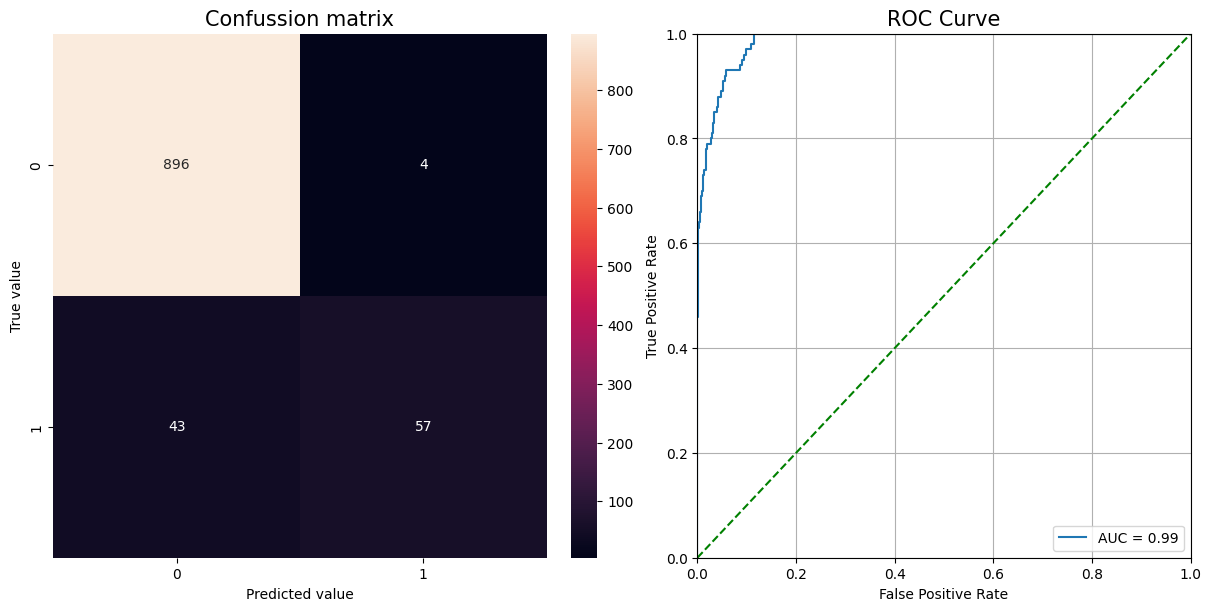

In [54]:
# 4. graph evalaluation
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')
def cm_gbc_cf(ax, fontsize = 14):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('True value')
    ax.set_title('Confussion matrix', fontsize=fontsize+1)

def curve_gbc_cf(ax, fontsize = 14):
    y_pred_proba = model_gbc.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label =f'AUC = {auc:.2f}')
    ax.plot([0, 1], [0, 1], linestyle='--', color = 'green')
    ax.grid('-')
    ax.set_xlim(0, 1)  # Límites del eje x
    ax.set_ylim(0, 1)  # Límites del eje y
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title('ROC Curve', fontsize=fontsize+1)
    ax.legend()

cm_gbc_cf(axs[0], fontsize=14)
curve_gbc_cf(axs[1], fontsize = 14)

##### XGBoost (eXtreme Gradient Boosting)
`XGBoost` is an optimized and scalable implementation of the algorithm **Gradient Boosting**. Is a **ensemble learning** method which combines predictions of many weak models (generally Decision Trees) to create a strong model.


`How it works?`

XGBoost follows an additive approach, where models are trained sequentially to correct the errors of the previous models. Here I explain the process step by step:

**1. Initialization**
- Starts with an initial prediction (i.e, the mean of the target variable in regression or the initial probability nin classification)

**2. Sequencial Training**

a). Residual calculations:
- For each sample, calculates a residual
- In classification uses the gradients of loss function

b). Train a Decision Tree:
- Train a Decision Tree to predict the residuals
- The tree adjust the los function to minimize (i.e, quadtratic error in regression or log-loss in clasification)

c). Update predictions:
- Predictions are updated by summing the predictions of the new tree, multiplied by a learning rate ($\eta$).

d). Repetition
- Steps a->b are repeated to add more trees to the model.

**3. Final prediction** 

The final prediction is the weighted sum of the predictions of all the trees.

`Hyperparameters of XGBoost`

- *n_estimators*: Number of trees in the ensemble
- *learning_rate*($\eta$): Controls the contribution of each tree
- $\dots$ [Check documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier )





In [55]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

model_xgb = XGBClassifier(
    n_estimators = 50,
    learning_rate= .1,
    tree_method="hist")
# 1. train the model
model_xgb.fit(X_train, y_train)
# 2. predict in the test of X
y_pred = model_xgb.predict(X_test)
# 3. evaluation
print(classification_report(y_test, y_pred))
cv_xgb_cf = cross_val_score(estimator=model_xgb, X=X_train, y=y_train, cv=5)
print(f"Cross Validation Score: {cv_xgb_cf.mean(): .3f}")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       900
           1       0.98      0.58      0.73       100

    accuracy                           0.96      1000
   macro avg       0.97      0.79      0.85      1000
weighted avg       0.96      0.96      0.95      1000

Cross Validation Score:  0.960


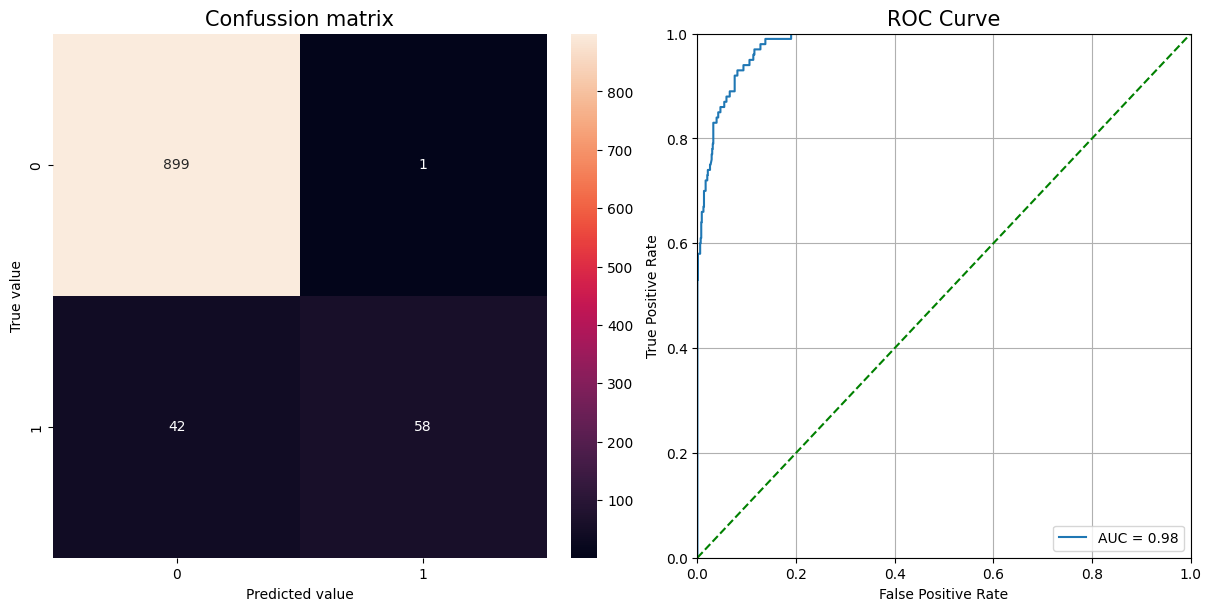

In [56]:
# 4. graph evalaluation
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')
def cm_xgb_cf(ax, fontsize = 14):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('True value')
    ax.set_title('Confussion matrix', fontsize=fontsize+1)

def curve_xgb_cf(ax, fontsize = 14):
    y_pred_proba = model_xgb.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label =f'AUC = {auc:.2f}')
    ax.plot([0, 1], [0, 1], linestyle='--', color = 'green')
    ax.grid('-')
    ax.set_xlim(0, 1)  # Límites del eje x
    ax.set_ylim(0, 1)  # Límites del eje y
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title('ROC Curve', fontsize=fontsize+1)
    ax.legend()

cm_xgb_cf(axs[0], fontsize=14)
curve_xgb_cf(axs[1], fontsize = 14)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

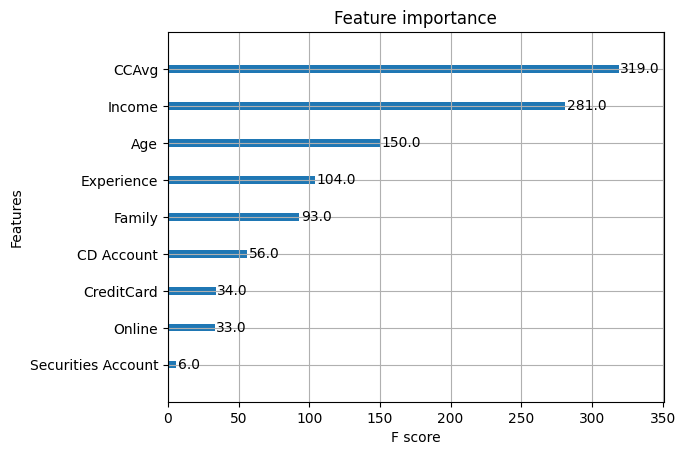

In [57]:
from xgboost import plot_importance
plot_importance(model_xgb)

#### LightGBM
`LightGBM` (**Light Gradient Boosting Machine**) is an implementation of Gradient Boosting developed by Microsoft. Is designed to be fast and efficient, specially with *larges* volumes of data. Uses techniques like **histogram-based splitting** and **lead-wise growth** to better performance.

`How it works?`

Follows the Gradient Boosting approach, but with key optimizations:

**1. Histogram-based splitting**

- Instead of evaluate all possible points of division for each feature, LightGBM groups the values in **bins**(containers) and evaluate the divisions bases in this bins. Which reduces the computational.

**2. Leaf-wise growth**

- Instead of grow level by level (like in traditional trees), LightGBM grows **leaf by leaf**, selecting the leaf that maximizes the loss function. This allow deeper and more precise trees.

**3. Large datasets support**

- Is optimized to handle large datasets and features.

`Hyperparameters of LightGBM`
- *num_leaves*: maximum number of leafs of a tree
- *learning_rate*: learning rate
- $\dots$ [Check documentation](https://lightgbm.readthedocs.io/en/stable/Parameters.html#core-parameters)

In [58]:
from lightgbm import LGBMClassifier

model_lgb = LGBMClassifier(
    n_estimators=1000,  # Número alto de estimadores (early stopping lo ajustará)
    learning_rate=0.1,
    max_depth=5,
    min_data_in_leaf=20,
    verbose=-1
)
# 1. train the model
model_lgb.fit(X_train, y_train)
# 2. predict the target in test
y_pred = model_lgb.predict(X_test)
# 3. evaluation
cv_lgb_cf = cross_val_score(estimator=model_lgb, X=X_train, y=y_train, cv=10)
print(f"Cross Validation Score: {cv_lgb_cf.mean(): .3f}")
print(f"Classification Report\n{classification_report(y_test, y_pred)}")

Cross Validation Score:  0.963
Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       900
           1       0.96      0.66      0.78       100

    accuracy                           0.96      1000
   macro avg       0.96      0.83      0.88      1000
weighted avg       0.96      0.96      0.96      1000



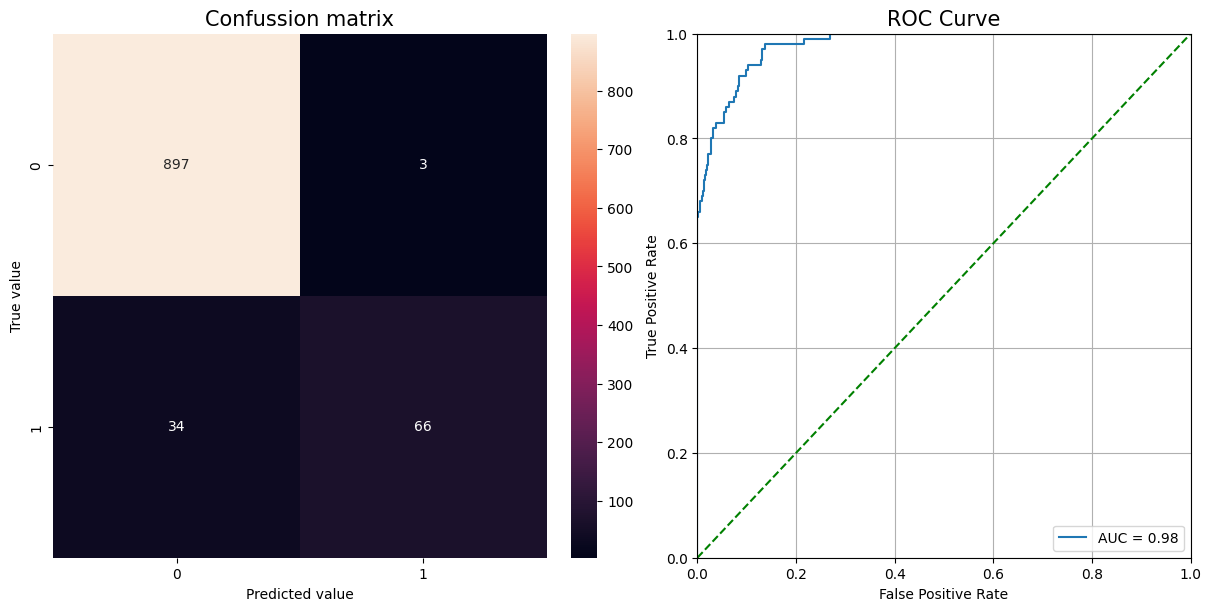

In [59]:
# 4. graph evalaluation
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')
def cm_lgb_cf(ax, fontsize = 14):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('True value')
    ax.set_title('Confussion matrix', fontsize=fontsize+1)

def curve_lgb_cf(ax, fontsize = 14):
    y_pred_proba = model_lgb.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label =f'AUC = {auc:.2f}')
    ax.plot([0, 1], [0, 1], linestyle='--', color = 'green')
    ax.grid('-')
    ax.set_xlim(0, 1)  # limites del eje x
    ax.set_ylim(0, 1)  # lmites del eje y
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title('ROC Curve', fontsize=fontsize+1)
    ax.legend()

cm_lgb_cf(axs[0], fontsize=14)
curve_lgb_cf(axs[1], fontsize = 14)

#### CatBoost
`CatBoost` (**Categorical Boosting**) is a implementation of Gradient Boosting. Is designed to handle categorical variables without needing of additional preprocessing.

`How it works?`

CatBoost follows the Gradient Boosting approach but with key optimizations:

**1. Automatic handling of categoric variables**
CatBoost automatically converts categorical variables into numeric values using techniques such as Target Encoding and Ordered Target Encoding. This eliminates the need for manual encoding (such as One-Hot Encoding).

**2. Ordered Boosting**
- CatBoot uses a technique called **Ordered Boosting** to reduce overfitting. Instead of using the whole dataset to calculate residuals, uses a ordered subset of the data

**3. Robustness against overfitting**
CatBoost includes techniques such as regularization and feature permutations to improve model generalization.

`Hyperparameters`

- *iterations*: number of trees on the ensemble
- *learning_rate*: learning rate
- $\dots$ [Check documentation](https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier)

In [60]:
from catboost import CatBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), random_state=42)

model_cbc = CatBoostClassifier(
    iterations=100,
    learning_rate=.1,
    depth=6,
    verbose=0
)
# 1. train model
model_cbc.fit(X_train, y_train)
# 2. predict for X_test
y_pred = model_cbc.predict(X_test)
# 3. evaluation
cv_cbc_cf = cross_val_score(estimator=model_cbc, X=X_train, y=y_train, cv=10)
print(f"Cross Validation Score: {cv_cbc_cf.mean(): .3f}")
print(f"{classification_report(y_pred, y_test)}")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

I didnt use CatBoost because of incompatibility with my installed packages

#### Stacking
